## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

In [113]:
import pandas as pd
import psycopg2
import requests
import plotly.express as px
import json
from IPython.display import JSON
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [114]:
def flights_data(table, limit):
    conn = psycopg2.connect(database="mid_term_project", user="lhl_student", password="lhl_student", host="mid-term-project.ca2jkepgjpne.us-east-2.rds.amazonaws.com", port="5432")
    df = pd.read_sql_query(f'''SELECT * FROM {table} ORDER BY random() LIMIT {limit};''', conn)
    print("Database downloaded successfully")
    return df

In [104]:
conn = psycopg2.connect(database="mid_term_project", user="lhl_student", password="lhl_student", host="mid-term-project.ca2jkepgjpne.us-east-2.rds.amazonaws.com", port="5432")

In [ ]:
df = flights_data('flights', 100000)


In [116]:
df = pd.read_csv('Project_Files/raw_data100k.csv')

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

In [9]:
df = pd.read_csv('Project_Files/arr_delay.csv', sep=',')
df = df.drop(columns = 'Unnamed: 0')

In [10]:
df.head(5)

,fl_date,arr_delay
0,2018-10-06,-20.0
1,2018-10-06,-34.0
2,2018-10-06,-22.0
3,2018-10-06,-10.0
4,2018-10-06,-1.0


In [38]:
df.describe()

,arr_delay
count,97925.000000
mean,7.920694
std,47.660122
min,-104.000000
25%,-13.000000
50%,-4.000000
75%,11.000000
max,1537.000000


In [39]:
arr_delay = df['arr_delay'].values
arr_delay

array([-20., -34., -22., ...,  nan,  nan,  nan])

In [73]:
statistic, pvalue = st.shapiro(arr_delay[0:500])

In [74]:
print(statistic, pvalue)

nan 1.0


p-value is > 0.05 so data is not normal

<AxesSubplot:xlabel='arr_delay', ylabel='Count'>

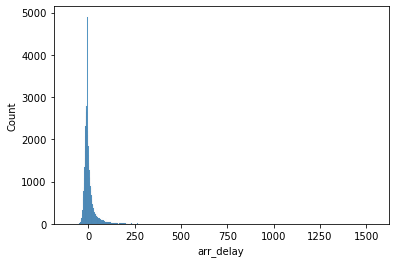

In [42]:
sns.histplot(df['arr_delay'])

In [43]:
max(df['arr_delay'])

1537.0

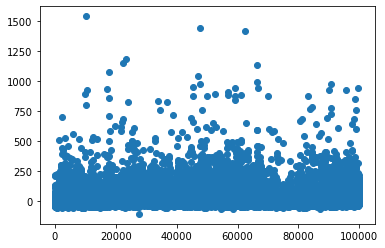

In [44]:
plt.scatter(x=df.index, y=df['arr_delay'])

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [13]:
month_df = pd.read_csv('Project_Files/month_delay.csv', sep=',')
month_df = month_df.drop(columns = 'Unnamed: 0')
month_df.head()

,fl_date,arr_delay,flights
0,2018-12-05,-9.0,1.0
1,2019-10-30,-16.0,1.0
2,2019-04-14,52.0,1.0
3,2019-03-07,-9.0,1.0
4,2019-09-10,-14.0,1.0


In [14]:
month_df['fl_date'] = pd.to_datetime(month_df['fl_date'])

In [15]:
month_df.dtypes

fl_date      datetime64[ns]
arr_delay           float64
flights             float64
dtype: object

In [16]:
month_df['fl_month'] = month_df['fl_date'].dt.month

In [17]:
avg_delay_mth = month_df.groupby('fl_month')['arr_delay'].mean()
num_flights_mth = month_df.groupby('fl_month')['flights'].sum()

Summer months are busier and seem to have more delays. 

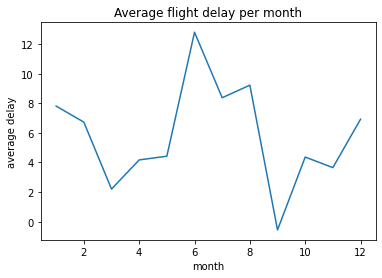

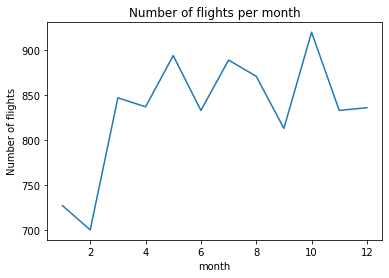

In [18]:
plt.plot(avg_delay_mth.index, avg_delay_mth.values)
plt.xlabel('month')
plt.ylabel('average delay')
plt.title('Average flight delay per month')
plt.show()

plt.plot(num_flights_mth.index, num_flights_mth.values)
plt.xlabel('month')
plt.ylabel('Number of flights')
plt.title('Number of flights per month')
plt.show()

In [21]:
month_df.groupby('fl_month').median()

,arr_delay,flights
fl_month,,
1,-6.0,1.0
2,-5.0,1.0
3,-7.0,1.0
4,-6.0,1.0
5,-6.0,1.0
6,-4.0,1.0
7,-6.0,1.0
8,-5.0,1.0
9,-8.0,1.0


In [25]:
month_df.describe()

,arr_delay,flights,fl_month
count,9818.000000,10000.0,10000.00000
mean,5.817071,1.0,6.63870
std,49.039556,0.0,3.38383
min,-60.000000,1.0,1.00000
25%,-14.750000,1.0,4.00000
50%,-6.000000,1.0,7.00000
75%,7.000000,1.0,10.00000
max,1081.000000,1.0,12.00000


In [24]:
month_df.shape

(10000, 4)

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [26]:
df = pd.read_csv('Project_Files/raw_data100k.csv')

In [35]:
weather_df = pd.read_csv('Project_Files/weather_data.csv')
weather_df = weather_df.rename(columns ={'airport': 'dest'})

In [36]:
weather_df = pd.merge(df, weather_df, on=["fl_date", "dest"], how = 'inner')

In [37]:
weather_df = weather_df[['fl_date', 'arr_delay', 'weather']]

In [39]:
weather_df = weather_df.groupby('weather')['arr_delay'].agg(Mean='mean', Median='median', Min = 'min', Max=max)


In [40]:
weather_df

,Mean,Median,Min,Max
weather,,,,
cloudy,1.374785,-8.0,-73.0,981.0
rainy,10.514902,-3.0,-58.0,1268.0
snow,20.654088,-2.0,-63.0,922.0
sunny,-2.934949,-9.0,-54.0,933.0
wind,0.516845,-9.0,-61.0,1058.0


#### **Task 4**: How are taxi times changing during the day? Does higher traffic lead to bigger taxi times?

In [41]:
sample_df = pd.read_csv('Project_Files/sample.csv', sep=',')
sample_df = sample_df.drop(columns=['Unnamed: 0'])
sample_df.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2018-06-18,DL,DL,DL,2653,DL,N321US,2653,14492,RDU,...,356.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-11-30,DL,DL_CODESHARE,DL,5211,9E,N8980A,5211,13487,MSP,...,175.0,0.0,0.0,29.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2018-10-23,AA,AA_CODESHARE,AA,4715,YX,N124HQ,4715,14576,ROC,...,573.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-04-29,AA,AA,AA,2807,AA,N957AN,2807,13303,MIA,...,204.0,21.0,0.0,9.0,0.0,0.0,NaN,NaN,NaN,NaN
4,2018-07-17,UA,UA_CODESHARE,UA,5698,OO,N925EV,5698,13930,ORD,...,84.0,0.0,0.0,0.0,0.0,44.0,NaN,NaN,NaN,NaN


In [42]:
sample_df['fl_date'] = pd.to_datetime(sample_df['fl_date'])

In [43]:
taxi_df = sample_df[['fl_date', 'crs_dep_time', 'dep_time', 'taxi_out', 'taxi_in', 'crs_arr_time', 'arr_time', 'flights']]
taxi_df = taxi_df.sort_values(['fl_date', 'dep_time'])
taxi_df.head()

,fl_date,crs_dep_time,dep_time,taxi_out,taxi_in,crs_arr_time,arr_time,flights
80580,2018-01-01,530,533.0,13.0,3.0,825,811.0,1.0
14804,2018-01-01,540,540.0,25.0,5.0,1145,1148.0,1.0
85278,2018-01-01,550,549.0,18.0,9.0,728,716.0,1.0
50962,2018-01-01,555,554.0,25.0,3.0,655,703.0,1.0
23572,2018-01-01,1630,556.0,37.0,4.0,1930,856.0,1.0


In [44]:
taxi_df.dtypes

fl_date         datetime64[ns]
crs_dep_time             int64
dep_time               float64
taxi_out               float64
taxi_in                float64
crs_arr_time             int64
arr_time               float64
flights                float64
dtype: object

<AxesSubplot:xlabel='dep_time', ylabel='taxi_out'>

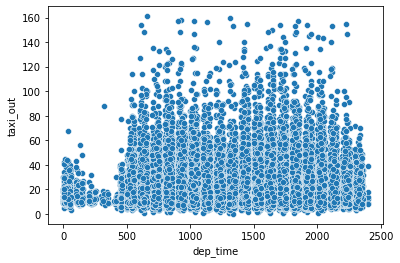

In [45]:
sns.scatterplot(x='dep_time', y='taxi_out', data=taxi_df)

<AxesSubplot:xlabel='arr_time', ylabel='taxi_in'>

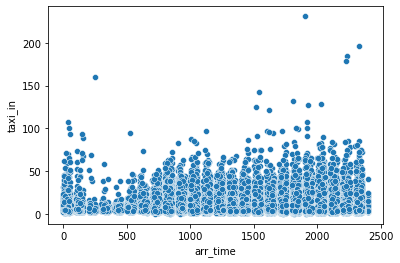

In [46]:
sns.scatterplot(x='arr_time', y='taxi_in', data=taxi_df)

# do sum of flights per hour relative to mean of taxi_in per hour

In [47]:
mean_taxi_out = taxi_df.groupby(taxi_df['dep_time']//100 * 100)['taxi_out'].mean()
mean_taxi_in = taxi_df.groupby(taxi_df['arr_time']//100 * 100)['taxi_in'].mean()
flights_per_hour = taxi_df.groupby(taxi_df['dep_time']//100 * 100)['flights'].sum()

In [48]:
type(flights_per_hour)

pandas.core.series.Series

In [49]:
df_agg = pd.DataFrame({'taxi_out': mean_taxi_out, 'taxi_in': mean_taxi_in, 'Flights': flights_per_hour})
df_agg

,taxi_out,taxi_in,Flights
0.0,15.943205,7.202149,493.0
100.0,15.000000,7.291096,202.0
200.0,13.840909,6.704545,44.0
300.0,13.621622,8.137255,37.0
400.0,15.376000,6.642276,250.0
500.0,17.216847,7.790030,3597.0
600.0,17.851240,7.911345,6050.0
700.0,18.981885,8.170366,5964.0
800.0,20.876662,8.995004,6247.0
900.0,19.953727,8.468220,5948.0


Text(0, 0.5, 'Number of Flights')

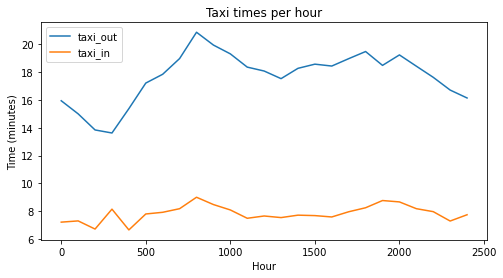

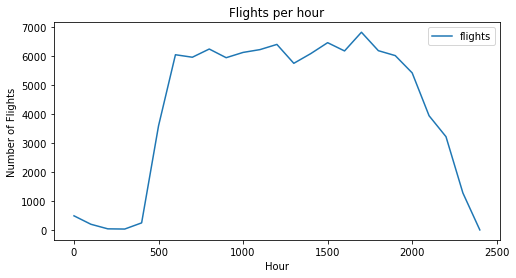

In [50]:
fix, ax = plt.subplots(figsize=(8,4))
ax.plot(df_agg.index, df_agg['taxi_out'], label='taxi_out')
ax.plot(df_agg.index, df_agg['taxi_in'], label='taxi_in')
ax.legend(loc='best')
ax.set_title('Taxi times per hour')
ax.set_xlabel('Hour')
ax.set_ylabel('Time (minutes)')
fix, ax = plt.subplots(figsize=(8,4))
ax.plot(df_agg.index, df_agg['Flights'], label='flights')
ax.legend(loc='best')
ax.set_title('Flights per hour')
ax.set_xlabel('Hour')
ax.set_ylabel('Number of Flights')

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

In [51]:
delays = sample_df[['fl_date', 'crs_dep_time', 'dep_time', 'dep_delay', 'arr_delay', 'actual_elapsed_time', 'crs_arr_time', 'arr_time']]
delays = delays.copy()

In [52]:
delays = delays.dropna()

In [54]:
del1 = delays[['fl_date', 'dep_delay', 'arr_delay']]

In [55]:
dep_delayed = del1[del1['dep_delay']>0].shape[0]
total = del1.shape[0]
percent_delayed_dep = dep_delayed/total * 100
percent_delayed_dep

43.65080877169585

In [56]:
arr_delayed = del1[del1['arr_delay']>0].shape[0]
total = del1.shape[0]
percent_delayed_arr = arr_delayed/total * 100
percent_delayed_arr

52.386305180330375

In [57]:
delays.fl_date = delays.fl_date.astype(str)

In [58]:
delays.dtypes

fl_date                 object
crs_dep_time             int64
dep_time               float64
dep_delay              float64
arr_delay              float64
actual_elapsed_time    float64
crs_arr_time             int64
arr_time               float64
dtype: object

In [59]:
delays.head()

,fl_date,crs_dep_time,dep_time,dep_delay,arr_delay,actual_elapsed_time,crs_arr_time,arr_time
0,2018-06-18,730,723.0,-7.0,3.0,96.0,856,859.0
1,2019-11-30,1019,1014.0,-5.0,29.0,92.0,1117,1146.0
2,2018-10-23,1850,1842.0,-8.0,1.0,134.0,2055,2056.0
3,2019-04-29,1335,1356.0,21.0,30.0,72.0,1438,1508.0
4,2018-07-17,1944,2035.0,51.0,44.0,44.0,2135,2219.0


In [60]:
delays = delays.dropna()

In [61]:
delays['dep_time'] = delays['dep_time'].astype(int)
delays['arr_time'] = delays['arr_time'].astype(int)

In [62]:
delays['crs_dep_time'] = delays['crs_dep_time'].astype(str)
delays['crs_arr_time'] = delays['crs_arr_time'].astype(str)
delays['dep_time'] = delays['dep_time'].astype(str)
delays['arr_time'] = delays['arr_time'].astype(str)

In [63]:
delays.dtypes

fl_date                 object
crs_dep_time            object
dep_time                object
dep_delay              float64
arr_delay              float64
actual_elapsed_time    float64
crs_arr_time            object
arr_time                object
dtype: object

In [64]:
delays['crs_dep_time'] = delays['crs_dep_time'].apply(lambda x: str(x).zfill(4))
delays['crs_arr_time'] = delays['crs_arr_time'].apply(lambda x: str(x).zfill(4))
delays['dep_time'] = delays['dep_time'].apply(lambda x: str(x).zfill(4))
delays['arr_time'] = delays['arr_time'].apply(lambda x: str(x).zfill(4))

In [65]:
delays['dep_time_h'] = delays['dep_time'].str[0:2]
delays['dep_time_m'] = delays['dep_time'].str[2:]
delays['dep_time_h'] = delays['dep_time_h'].replace('24', '00')

delays['arr_time_h'] = delays['arr_time'].str[0:2]
delays['arr_time_m'] = delays['arr_time'].str[2:]
delays['arr_time_h'] = delays['arr_time_h'].replace('24', '00')

delays['crs_dep_time_h'] = delays['crs_dep_time'].str[0:2]
delays['crs_dep_time_m'] = delays['crs_dep_time'].str[2:]
delays['crs_dep_time_h'] = delays['crs_dep_time_h'].replace('24', '00')

delays['crs_arr_time_h'] = delays['crs_arr_time'].str[0:2]
delays['crs_arr_time_m'] = delays['crs_arr_time'].str[2:]
delays['crs_arr_time_h'] = delays['crs_arr_time_h'].replace('24', '00')

delays['dep_time'] = delays['dep_time_h']+delays['dep_time_m']
delays['arr_time'] = delays['arr_time_h']+delays['arr_time_m']
delays['crs_dep_time'] = delays['crs_dep_time_h']+delays['crs_dep_time_m']
delays['crs_arr_time'] = delays['crs_arr_time_h']+delays['crs_arr_time_m']

In [1405]:
#delays.drop(columns = ['dep_time_h', 'dep_time_m', 'arr_time_h', 'arr_time_m'])

In [66]:
delays['crs_dep_time_hour'] = delays['crs_dep_time'].apply(lambda x: dt.datetime.strptime(str(x),  '%H%M').hour)
delays['crs_dep_time_min'] = delays['crs_dep_time'].apply(lambda x: dt.datetime.strptime(str(x),  '%H%M').minute)
delays['crs_arr_time_hour'] = delays['crs_arr_time'].apply(lambda x: dt.datetime.strptime(str(x),  '%H%M').hour)
delays['crs_arr_time_min'] = delays['crs_arr_time'].apply(lambda x: dt.datetime.strptime(str(x),  '%H%M').minute)

delays['dep_time_hour'] = delays['dep_time'].apply(lambda x: dt.datetime.strptime(str(x),  '%H%M').hour)
delays['dep_time_min'] = delays['dep_time'].apply(lambda x: dt.datetime.strptime(str(x),  '%H%M').minute)
delays['arr_time_hour'] = delays['arr_time'].apply(lambda x: dt.datetime.strptime(str(x),  '%H%M').hour)
delays['arr_time_min'] = delays['arr_time'].apply(lambda x: dt.datetime.strptime(str(x),  '%H%M').minute)

In [67]:
delays['crs_dep_time_hour'] = delays['crs_dep_time_hour'].apply(lambda x: str(x).zfill(2))
delays['crs_dep_time_min'] = delays['crs_dep_time_min'].apply(lambda x: str(x).zfill(2))
delays['crs_arr_time_hour'] = delays['crs_arr_time_hour'].apply(lambda x: str(x).zfill(2))
delays['crs_arr_time_min'] = delays['crs_arr_time_min'].apply(lambda x: str(x).zfill(2))

delays['dep_time_hour'] = delays['dep_time_hour'].apply(lambda x: str(x).zfill(2))
delays['dep_time_min'] = delays['dep_time_min'].apply(lambda x: str(x).zfill(2))
delays['arr_time_hour'] = delays['arr_time_hour'].apply(lambda x: str(x).zfill(2))
delays['arr_time_min'] = delays['arr_time_min'].apply(lambda x: str(x).zfill(2))

In [68]:
delays['crs_dep_time_2'] = delays['crs_dep_time_hour'].apply(lambda x: str(x)) + ':' + delays['crs_dep_time_min'].apply(lambda x: str(x))
delays['crs_arr_time_2'] = delays['crs_arr_time_hour'].apply(lambda x: str(x)) + ':' + delays['crs_arr_time_min'].apply(lambda x: str(x))

delays['dep_time_2'] = delays['dep_time_hour'].apply(lambda x: str(x)) + ':' + delays['dep_time_min'].apply(lambda x: str(x))
delays['arr_time_2'] = delays['arr_time_hour'].apply(lambda x: str(x)) + ':' + delays['arr_time_min'].apply(lambda x: str(x))

In [69]:
delays.dtypes

fl_date                 object
crs_dep_time            object
dep_time                object
dep_delay              float64
arr_delay              float64
actual_elapsed_time    float64
crs_arr_time            object
arr_time                object
dep_time_h              object
dep_time_m              object
arr_time_h              object
arr_time_m              object
crs_dep_time_h          object
crs_dep_time_m          object
crs_arr_time_h          object
crs_arr_time_m          object
crs_dep_time_hour       object
crs_dep_time_min        object
crs_arr_time_hour       object
crs_arr_time_min        object
dep_time_hour           object
dep_time_min            object
arr_time_hour           object
arr_time_min            object
crs_dep_time_2          object
crs_arr_time_2          object
dep_time_2              object
arr_time_2              object
dtype: object

In [1410]:
#delays = delays[['fl_date', 'actual_elapsed_time', 'crs_dep_time_2', 'crs_arr_time_2', 'dep_time_2', 'arr_time_2']]
#delays=delays.copy()
#delays.head()

In [70]:
delays = delays.copy()
delays['dep_next_day'] = 0
delays['arr_next_day'] = 0

In [71]:
delays['dep_time_h'][0]

'07'

In [72]:
#delays['dep_time_h'].shape

In [73]:
a = 23
b = 2
if b - a < -2:
    print('yes')

yes


In [74]:
for i in range(len(delays['dep_time_h'])):
    if (int(delays.iloc[i]['dep_time_h']) - int(delays.iloc[i]['crs_dep_time_h'])) < -2:
        delays.iloc[i]['dep_next_day'] = 1
    else:
        delays.iloc[i]['dep_next_day'] = 0
        
for i in range(len(delays['arr_time_h'])):
    if (int(delays.iloc[i]['arr_time_h']) - int(delays.iloc[i]['crs_arr_time_h'])) < -2:
        delays.iloc[i]['arr_next_day'] = 1
    else:
        delays.iloc[i]['arr_next_day'] = 0

<ipython-input-74-0e2d9bc7318d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delays.iloc[i]['dep_next_day'] = 0
<ipython-input-74-0e2d9bc7318d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delays.iloc[i]['dep_next_day'] = 1
<ipython-input-74-0e2d9bc7318d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delays.iloc[i]['arr_next_day'] = 0
<ipython-input-74-0e2d9bc7318d>:9: SettingWithCopyWarning: 
A value is trying to be set on

KeyboardInterrupt: 

In [ ]:
delays['crs_dep_time_3'] = delays.fl_date + ' ' + delays.crs_dep_time_2
delays['crs_arr_time_3'] = delays.fl_date + ' ' + delays.crs_arr_time_2

delays['dep_time_3'] = delays.fl_date + ' ' + delays.dep_time_2
delays['arr_time_3'] = delays.fl_date + ' ' + delays.arr_time_2

In [1422]:
delays['crs_dep_time_3'] = pd.to_datetime(delays['crs_dep_time_3'])
delays['crs_arr_time_3'] = pd.to_datetime(delays['crs_arr_time_3'])
delays['dep_time_3'] = pd.to_datetime(delays['dep_time_3'])
delays['arr_time_3'] = pd.to_datetime(delays['arr_time_3'])

In [1423]:
delays.dtypes

fl_date                        object
crs_dep_time                   object
dep_time                       object
actual_elapsed_time           float64
crs_arr_time                   object
arr_time                       object
dep_time_h                     object
dep_time_m                     object
arr_time_h                     object
arr_time_m                     object
crs_dep_time_h                 object
crs_dep_time_m                 object
crs_arr_time_h                 object
crs_arr_time_m                 object
crs_dep_time_hour              object
crs_dep_time_min               object
crs_arr_time_hour              object
crs_arr_time_min               object
dep_time_hour                  object
dep_time_min                   object
arr_time_hour                  object
arr_time_min                   object
crs_dep_time_2                 object
crs_arr_time_2                 object
dep_time_2                     object
arr_time_2                     object
dep_next_day

In [1424]:
delays

,fl_date,crs_dep_time,dep_time,actual_elapsed_time,crs_arr_time,arr_time,dep_time_h,dep_time_m,arr_time_h,arr_time_m,...,crs_dep_time_2,crs_arr_time_2,dep_time_2,arr_time_2,dep_next_day,arr_next_day,crs_dep_time_3,crs_arr_time_3,dep_time_3,arr_time_3
0,2019-12-07,1550,1545,63.0,1655,1648,15,45,16,48,...,15:50,16:55,15:45,16:48,0,0,2019-12-07 15:50:00,2019-12-07 16:55:00,2019-12-07 15:45:00,2019-12-07 16:48:00
1,2019-04-06,0835,0829,309.0,1153,1238,08,29,12,38,...,08:35,11:53,08:29,12:38,0,0,2019-04-06 08:35:00,2019-04-06 11:53:00,2019-04-06 08:29:00,2019-04-06 12:38:00
2,2019-07-12,1925,1918,370.0,2235,2228,19,18,22,28,...,19:25,22:35,19:18,22:28,0,0,2019-07-12 19:25:00,2019-07-12 22:35:00,2019-07-12 19:18:00,2019-07-12 22:28:00
3,2019-08-23,1802,1821,215.0,1948,1956,18,21,19,56,...,18:02,19:48,18:21,19:56,0,0,2019-08-23 18:02:00,2019-08-23 19:48:00,2019-08-23 18:21:00,2019-08-23 19:56:00
4,2019-11-26,1315,1312,110.0,1603,1602,13,12,16,02,...,13:15,16:03,13:12,16:02,0,0,2019-11-26 13:15:00,2019-11-26 16:03:00,2019-11-26 13:12:00,2019-11-26 16:02:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2018-10-31,1645,2016,99.0,1826,2155,20,16,21,55,...,16:45,18:26,20:16,21:55,0,0,2018-10-31 16:45:00,2018-10-31 18:26:00,2018-10-31 20:16:00,2018-10-31 21:55:00
9996,2019-07-14,0805,0800,78.0,0930,0918,08,00,09,18,...,08:05,09:30,08:00,09:18,0,0,2019-07-14 08:05:00,2019-07-14 09:30:00,2019-07-14 08:00:00,2019-07-14 09:18:00
9997,2019-10-09,1650,1646,139.0,1846,1805,16,46,18,05,...,16:50,18:46,16:46,18:05,0,0,2019-10-09 16:50:00,2019-10-09 18:46:00,2019-10-09 16:46:00,2019-10-09 18:05:00
9998,2019-09-04,1855,1856,222.0,0040,0038,18,56,00,38,...,18:55,00:40,18:56,00:38,0,0,2019-09-04 18:55:00,2019-09-04 00:40:00,2019-09-04 18:56:00,2019-09-04 00:38:00


In [1425]:
delays['dep_next_day'] = pd.to_timedelta(delays['dep_next_day'], unit='day')
delays['arr_next_day'] = pd.to_timedelta(delays['arr_next_day'], unit='day')

In [1426]:
delays.dtypes

fl_date                         object
crs_dep_time                    object
dep_time                        object
actual_elapsed_time            float64
crs_arr_time                    object
arr_time                        object
dep_time_h                      object
dep_time_m                      object
arr_time_h                      object
arr_time_m                      object
crs_dep_time_h                  object
crs_dep_time_m                  object
crs_arr_time_h                  object
crs_arr_time_m                  object
crs_dep_time_hour               object
crs_dep_time_min                object
crs_arr_time_hour               object
crs_arr_time_min                object
dep_time_hour                   object
dep_time_min                    object
arr_time_hour                   object
arr_time_min                    object
crs_dep_time_2                  object
crs_arr_time_2                  object
dep_time_2                      object
arr_time_2               

In [1427]:
delays['dep_time_3'] = delays['dep_time_3']+delays['dep_next_day']
delays['arr_time_3'] = delays['arr_time_3']+delays['arr_next_day']

In [1435]:
delays['dep_delay'] = delays['dep_time_3'] - delays['crs_dep_time_3']
delays['arr_delay'] = delays['arr_time_3'] - delays['crs_arr_time_3']

In [1436]:
delays['dep_delay'] = delays['dep_delay'].apply(lambda x: x.total_seconds()/60)
delays['arr_delay'] = delays['arr_delay'].apply(lambda x: x.total_seconds()/60)

In [1437]:
delays

,fl_date,crs_dep_time,dep_time,actual_elapsed_time,crs_arr_time,arr_time,dep_time_h,dep_time_m,arr_time_h,arr_time_m,...,dep_time_2,arr_time_2,dep_next_day,arr_next_day,crs_dep_time_3,crs_arr_time_3,dep_time_3,arr_time_3,dep_delay,arr_delay
0,2019-12-07,1550,1545,63.0,1655,1648,15,45,16,48,...,15:45,16:48,0 days,0 days,2019-12-07 15:50:00,2019-12-07 16:55:00,2019-12-07 15:45:00,2019-12-07 16:48:00,-5.0,-7.0
1,2019-04-06,0835,0829,309.0,1153,1238,08,29,12,38,...,08:29,12:38,0 days,0 days,2019-04-06 08:35:00,2019-04-06 11:53:00,2019-04-06 08:29:00,2019-04-06 12:38:00,-6.0,45.0
2,2019-07-12,1925,1918,370.0,2235,2228,19,18,22,28,...,19:18,22:28,0 days,0 days,2019-07-12 19:25:00,2019-07-12 22:35:00,2019-07-12 19:18:00,2019-07-12 22:28:00,-7.0,-7.0
3,2019-08-23,1802,1821,215.0,1948,1956,18,21,19,56,...,18:21,19:56,0 days,0 days,2019-08-23 18:02:00,2019-08-23 19:48:00,2019-08-23 18:21:00,2019-08-23 19:56:00,19.0,8.0
4,2019-11-26,1315,1312,110.0,1603,1602,13,12,16,02,...,13:12,16:02,0 days,0 days,2019-11-26 13:15:00,2019-11-26 16:03:00,2019-11-26 13:12:00,2019-11-26 16:02:00,-3.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2018-10-31,1645,2016,99.0,1826,2155,20,16,21,55,...,20:16,21:55,0 days,0 days,2018-10-31 16:45:00,2018-10-31 18:26:00,2018-10-31 20:16:00,2018-10-31 21:55:00,211.0,209.0
9996,2019-07-14,0805,0800,78.0,0930,0918,08,00,09,18,...,08:00,09:18,0 days,0 days,2019-07-14 08:05:00,2019-07-14 09:30:00,2019-07-14 08:00:00,2019-07-14 09:18:00,-5.0,-12.0
9997,2019-10-09,1650,1646,139.0,1846,1805,16,46,18,05,...,16:46,18:05,0 days,0 days,2019-10-09 16:50:00,2019-10-09 18:46:00,2019-10-09 16:46:00,2019-10-09 18:05:00,-4.0,-41.0
9998,2019-09-04,1855,1856,222.0,0040,0038,18,56,00,38,...,18:56,00:38,0 days,0 days,2019-09-04 18:55:00,2019-09-04 00:40:00,2019-09-04 18:56:00,2019-09-04 00:38:00,1.0,-2.0


In [1431]:
#secondsDelta = delays['dep_delay'][0].total_seconds()
#secondsDelta

In [1432]:
#delays['dep_delay'][0].total_seconds()

In [1433]:
#minutesDelta = secondsDelta/60
#minutesDelta

In [1441]:
delays['arr_delay'].argmin()

342

In [1443]:
delays.iloc[342, :]

fl_date                         2018-02-06
crs_dep_time                          1800
dep_time                              1840
actual_elapsed_time                    203
crs_arr_time                          2355
arr_time                              0003
dep_time_h                              18
dep_time_m                              40
arr_time_h                              00
arr_time_m                              03
crs_dep_time_h                          18
crs_dep_time_m                          00
crs_arr_time_h                          23
crs_arr_time_m                          55
crs_dep_time_hour                       18
crs_dep_time_min                        00
crs_arr_time_hour                       23
crs_arr_time_min                        55
dep_time_hour                           18
dep_time_min                            40
arr_time_hour                           00
arr_time_min                            03
crs_dep_time_2                       18:00
crs_arr_tim

#### **Task 6**: How many states cover 50% of US air traffic? 

In [79]:
origin_city = pd.read_sql_query('''SELECT COUNT(origin_city_name), origin_city_name FROM flights GROUP BY origin_city_name;''', conn)

In [81]:
dest_city = pd.read_sql_query('''SELECT COUNT(dest_city_name), dest_city_name FROM flights GROUP BY dest_city_name;''', conn)

In [82]:
dest_city['state'] = dest_city['dest_city_name'].str[-2:]
dest_state = dest_city.groupby('state').sum().sort_values(by ='count',ascending=False).reset_index()
dest_state = dest_state.rename(columns={"count": "arrivals"})

In [83]:
origin_city['state'] = origin_city['origin_city_name'].str[-2:]
origin_state = origin_city.groupby('state').sum().sort_values(by ='count',ascending=False).reset_index()
origin_state = origin_state.rename(columns={"count": "depatures"})

In [84]:
half = 0
top_50 = 0
for _ in dest_state.arrivals:
    if half <= int(dest_state.arrivals.sum())/2:
        half += int(dest_state.arrivals[top_50])
        top_50 += 1

In [85]:
top_50

8

In [86]:
state = pd.merge(dest_state, origin_state, on=['state'], how = 'inner')

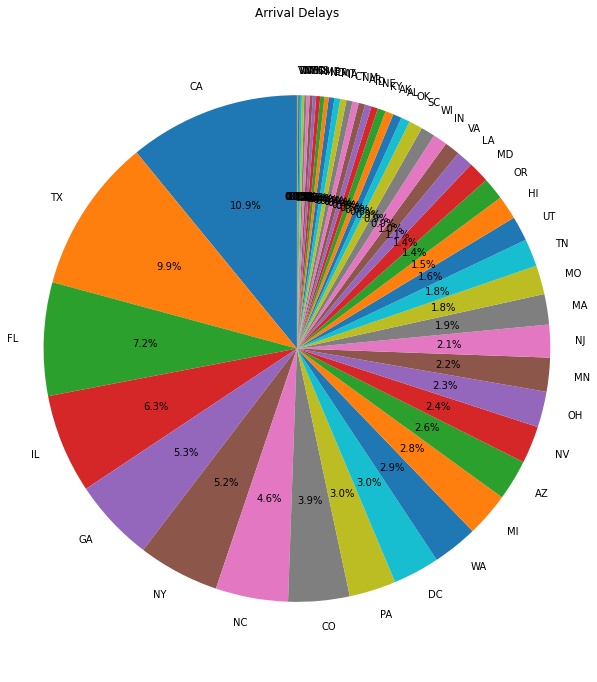

In [148]:
fig1, ax1 = plt.subplots(figsize=(10, 12))
plt.pie(state.arrivals,labels=state.state,autopct='%1.1f%%',startangle=90)
plt.title('Arrival Delays')
plt.axis('equal')
plt.show()

In [ ]:
fig1, ax1 = plt.subplots()
ax1.pie(sizes, , labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, textprops={'fontsize': 25})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
figure(figsize=(8, 6), dpi=80)

plt.show()

In [87]:
state

,state,arrivals,depatures
0,CA,1738330,1738254
1,TX,1572051,1572078
2,FL,1151320,1151221
3,IL,1008051,1008184
4,GA,841095,841057
5,NY,827847,827854
6,NC,736070,736077
7,CO,622441,622430
8,PA,475222,475258
9,DC,472915,472958


#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

In [88]:
df_delay = df[['dep_delay', 'arr_delay']]

In [89]:
df_delay.head()

,dep_delay,arr_delay
0,-4.0,-9.0
1,NaN,NaN
2,-9.0,-21.0
3,0.0,41.0
4,88.0,121.0


/home/aj/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'arr_delay')

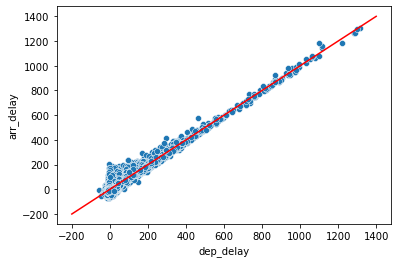

In [90]:
x_lim=[-200, 1400]
y_lim=[-200, 1400]
sns.scatterplot(x=df_delay['dep_delay'], y=df_delay['arr_delay'])
sns.lineplot(x_lim, y_lim, color='red')
plt.xlabel('dep_delay')
plt.ylabel('arr_delay')

Not really... arrival delays pretty closely match depature delays

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

In [91]:
df['crs_dep_time'] = df['crs_dep_time'].astype(int)
df['crs_arr_time'] = df['crs_arr_time'].astype(int)
df['crs_dep_time'] = df['crs_dep_time'].astype(str)
df['crs_arr_time'] = df['crs_arr_time'].astype(str)

# create departure hour and arrival hour columns
df['crs_dep_time'] = df['crs_dep_time'].apply(lambda x: str(x).zfill(4))
df['crs_arr_time'] = df['crs_arr_time'].apply(lambda x: str(x).zfill(4))
df['dep_h'] = df['crs_dep_time'].str[0:2]
df['arr_h'] = df['crs_arr_time'].str[0:2]
df['dep_h'] = df['dep_h'].replace('24', '00')
df['arr_h'] = df['arr_h'].replace('24', '00')

In [92]:
#short < 800
#medium between 800-2200
#long > 2200

df_short = df[df['distance']<800]
df_medium = df[(df['distance']>=800) & (df['distance']<2200)]
df_long = df[df['distance']>2200]

In [93]:
short_flights_per_h = df_short.groupby('dep_h')['flights'].count()
medium_flights_per_h = df_medium.groupby('dep_h')['flights'].count()
long_flights_per_h = df_long.groupby('dep_h')['flights'].count()

Text(0.5, 1.0, 'Number of short haul flights departing per hour')

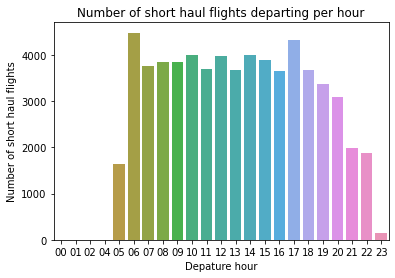

In [94]:
sns.barplot(x=short_flights_per_h.index, y=short_flights_per_h.values)
plt.xlabel('Depature hour')
plt.ylabel('Number of short haul flights')
plt.title('Number of short haul flights departing per hour')

Text(0.5, 1.0, 'Number of medium haul flights departing per hour')

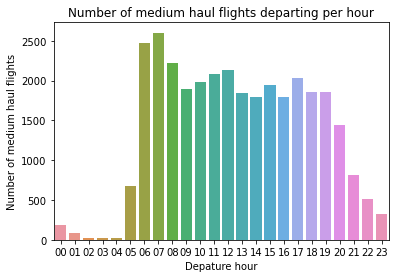

In [95]:
sns.barplot(x=medium_flights_per_h.index, y=medium_flights_per_h.values)
plt.xlabel('Depature hour')
plt.ylabel('Number of medium haul flights')
plt.title('Number of medium haul flights departing per hour')

Text(0.5, 1.0, 'Number of long haul flights departing per hour')

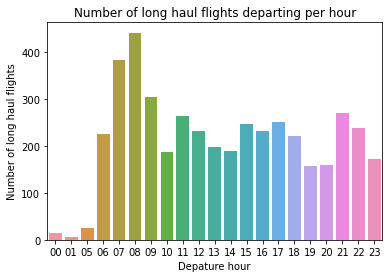

In [96]:
sns.barplot(x=long_flights_per_h.index, y=long_flights_per_h.values)
plt.xlabel('Depature hour')
plt.ylabel('Number of long haul flights')
plt.title('Number of long haul flights departing per hour')

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

In [97]:
df = pd.read_csv('Project_Files/sample.csv', sep=',')
df = df.drop(columns=['Unnamed: 0', 'branded_code_share', 'mkt_carrier', 'op_unique_carrier', 'tail_num', \
                      'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id', 'carrier_delay', 'weather_delay', \
                      'nas_delay', 'security_delay', 'late_aircraft_delay', 'first_dep_time', 'total_add_gtime', \
                      'longest_add_gtime', 'no_name', 'origin_city_name', 'dest_city_name', 'cancelled', \
                     'cancellation_code', 'diverted', 'dup'])
df.head()

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance
0,2018-06-18,DL,2653,RDU,ATL,730,723.0,-7.0,38.0,801.0,853.0,6.0,856,859.0,3.0,86.0,96.0,52.0,1.0,356.0
1,2019-11-30,DL,5211,MSP,CWA,1019,1014.0,-5.0,48.0,1102.0,1140.0,6.0,1117,1146.0,29.0,58.0,92.0,38.0,1.0,175.0
2,2018-10-23,AA,4715,ROC,CLT,1850,1842.0,-8.0,13.0,1855.0,2028.0,28.0,2055,2056.0,1.0,125.0,134.0,93.0,1.0,573.0
3,2019-04-29,AA,2807,MIA,TPA,1335,1356.0,21.0,22.0,1418.0,1458.0,10.0,1438,1508.0,30.0,63.0,72.0,40.0,1.0,204.0
4,2018-07-17,UA,5698,ORD,SBN,1944,2035.0,51.0,19.0,2054.0,2214.0,5.0,2135,2219.0,44.0,51.0,44.0,20.0,1.0,84.0


In [98]:
top_10_origin = df.groupby('origin')['flights'].count().sort_values(ascending=False).nlargest(10)
top_10_dest = df.groupby('dest')['flights'].count().sort_values(ascending=False).nlargest(10)

Text(0.5, 1.0, 'Top 10 busiest airports for flight origin')

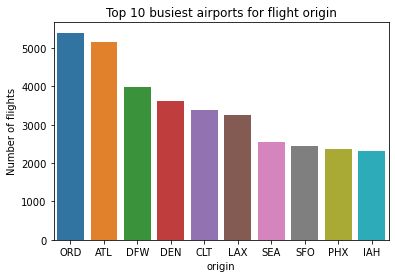

In [99]:
sns.barplot(x=top_10_origin.index, y=top_10_origin.values)
plt.xlabel('origin')
plt.ylabel('Number of flights')
plt.title('Top 10 busiest airports for flight origin')

Text(0.5, 1.0, 'Top 10 busiest airports for flight destination')

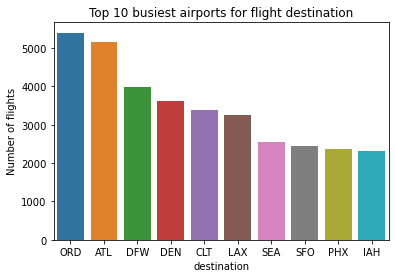

In [100]:
sns.barplot(x=top_10_origin.index, y=top_10_origin.values)
plt.xlabel('destination')
plt.ylabel('Number of flights')
plt.title('Top 10 busiest airports for flight destination')

In [101]:
top_10_late_carriers= df.groupby('mkt_unique_carrier')['arr_delay'].mean().sort_values(ascending=False).nlargest(10)

In [102]:
top_10_late_carriers

mkt_unique_carrier
B6    23.387049
UA    20.652960
F9    20.145955
NK    17.415372
G4    15.954741
AA    15.313070
DL    11.906707
WN    10.298015
VX     8.581967
AS     7.220975
Name: arr_delay, dtype: float64

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

In [105]:
passengers = pd.read_sql_query('''SELECT * FROM passengers ORDER BY RANDOM() LIMIT 10000;''', conn)

In [106]:
flights = pd.read_sql_query('''SELECT * FROM flights ORDER BY RANDOM() LIMIT 10000;''', conn)

In [107]:
fuel = pd.read_sql_query('''SELECT * FROM fuel_comsumption ORDER BY RANDOM() LIMIT 10000;''', conn)

In [108]:
avg_delay=flights[['op_unique_carrier','arr_delay']].groupby('op_unique_carrier').mean()
avg_delay=avg_delay.reset_index()
avg_delay.columns=['unique_carrier','arr_delay']

In [109]:
avg_fuel=fuel[['unique_carrier','total_gallons']].groupby('unique_carrier').mean()

In [110]:
total_cust_km=passengers[['unique_carrier','passengers','distance']]
total_cust_km['total_km']=total_cust_km['passengers']*total_cust_km['distance']
total_cust=total_cust_km[['unique_carrier','total_km']].groupby('unique_carrier').sum()

<ipython-input-110-21da266b7d82>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_cust_km['total_km']=total_cust_km['passengers']*total_cust_km['distance']


In [111]:
avg=avg_delay.merge(avg_fuel,on='unique_carrier')
avg=avg.merge(total_cust,on='unique_carrier')
avg['gal_per_km']=avg['total_gallons']/avg['total_km']
avg.sort_values(by='arr_delay',ascending=False)

,unique_carrier,arr_delay,total_gallons,total_km,gal_per_km
9,G7,22.544554,0.000000e+00,4.918746e+07,0.000000
7,F9,15.610294,1.974201e+07,3.299759e+08,0.059829
6,EV,14.118812,4.782577e+04,1.834337e+08,0.000261
3,B6,12.502825,6.608877e+07,1.139669e+09,0.057989
12,NK,8.906250,2.918083e+07,6.227024e+08,0.046862
13,OH,6.641096,0.000000e+00,1.208994e+08,0.000000
17,VX,6.545455,1.582843e+07,1.665559e+08,0.095034
16,UA,6.254194,2.799457e+08,4.301303e+09,0.065084
8,G4,5.674797,1.490811e+07,2.276576e+08,0.065485
20,YX,5.559809,5.036814e+06,1.613398e+08,0.031219


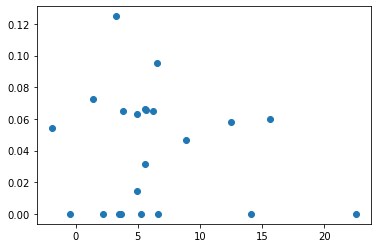

In [112]:
x=avg['arr_delay']
y=avg['gal_per_km']
plt.scatter(x,y)